In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.regressionplots import plot_partregress_grid

In [5]:
df = pd.read_csv( "data.csv" )

In [6]:
out_path = "./img2/"

In [ ]:
factor_cols = ['rmrf', 'smb', 'hml', 'umd']
xs_cols = [f'XS{i}' for i in range(1, 11)]

In [ ]:
# tieni solo le colonne necessarie e rimuovi righe con NaN
use = df[xs_cols + factor_cols].dropna().copy()

X = sm.add_constant(use[factor_cols])  # aggiunge l'intercetta

# --- run OLS for each XS ---
results = {}  # per riusare nei punti successivi
for xs in xs_cols:
    y = use[xs]
    model = sm.OLS(y, X)
    results[xs] = model.fit()

# check veloce: R^2 di ciascuna regressione
r2_overview = {k: v.rsquared for k, v in results.items()}
r2_overview

{'XS1': np.float64(0.6023094014514279),
 'XS2': np.float64(0.7194661097867887),
 'XS3': np.float64(0.7784512653622706),
 'XS4': np.float64(0.8297798783405157),
 'XS5': np.float64(0.8496115639555887),
 'XS6': np.float64(0.8876048551713996),
 'XS7': np.float64(0.9073382155420731),
 'XS8': np.float64(0.925850842768555),
 'XS9': np.float64(0.9218209513835791),
 'XS10': np.float64(0.9628818597217159)}

In [8]:
def plot_betas_with_ci(res, title='Betas with 95% CI'):
    params = res.params[['rmrf', 'smb', 'hml', 'umd']]
    ci = res.conf_int().loc[['rmrf', 'smb', 'hml', 'umd']]
    errs = params - ci[0], ci[1] - params  # asimmetriche

    plt.figure()
    ax = params.plot(kind='bar', yerr=list(errs), capsize=4)
    ax.set_ylabel('Beta')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_actual_vs_fitted(res, y, title='Actual vs Fitted'):
    fitted = res.fittedvalues
    plt.figure()
    plt.scatter(fitted, y, s=12)
    # linea 45°
    m = np.nanmin([fitted.min(), y.min()])
    M = np.nanmax([fitted.max(), y.max()])
    plt.plot([m, M], [m, M])
    plt.xlabel('Fitted')
    plt.ylabel('Actual')
    plt.title(f'{title} (R²={res.rsquared:.2f})')
    plt.tight_layout()
    plt.show()

In [49]:
pf = "XS10"

In [50]:
factors = ['const', 'rmrf', 'smb', 'hml', 'umd']

rows = []
for xs, res in results.items():
    for f in factors:
        rows.append({
            'portfolio': xs,
            'factor': f,
            'beta': res.params[f],
            't': res.tvalues[f],
            'p': res.pvalues[f]
        })
coef_tbl = pd.DataFrame(rows)

# aggiungo "stars" di significatività
def stars(p):
    return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''
coef_tbl['sig'] = coef_tbl['p'].apply(stars)

# esempio: vedi subito i risultati per XS*
coef_tbl.query(f"portfolio=='{pf}'").sort_values('factor')

,portfolio,factor,beta,t,p,sig
45,XS10,const,-0.000018,-0.037015,9.704935e-01,
48,XS10,hml,-0.008059,-0.564042,5.730791e-01,
46,XS10,rmrf,0.955129,95.085517,3.930187e-256,***
47,XS10,smb,-0.150017,-10.913667,3.936701e-24,***
49,XS10,umd,0.046646,3.582389,3.875487e-04,***


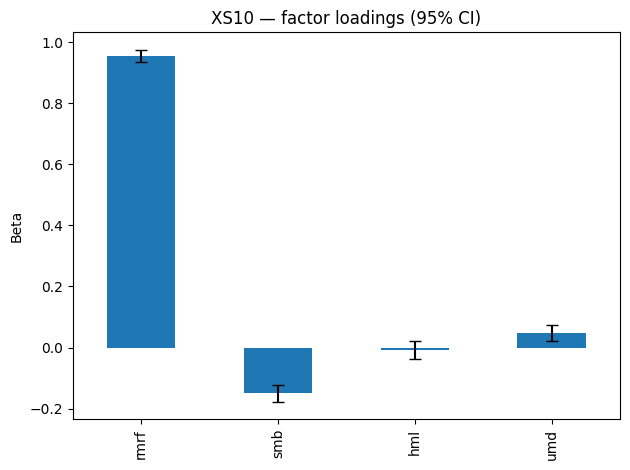

In [51]:
plot_betas_with_ci(results[pf], title=f'{pf} — factor loadings (95% CI)')

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6), constrained_layout=True)
axes = axes.ravel()

for ax, xs in zip(axes, xs_cols):
    res = results[xs]
    betas = res.params[factors]
    ci = res.conf_int().loc[factors]
    lower = betas - ci[0]
    upper = ci[1] - betas
    yerr = np.vstack([lower.values, upper.values])

    ax.bar(factors, betas.values, yerr=yerr, capsize=3)
    ax.axhline(0, lw=1, ls='--')
    ax.set_title(xs, fontsize=10)
    ax.set_ylabel('Beta')
    ax.tick_params(axis='x', labelrotation=0)

# se ci sono assi rimasti (nel caso non multiplo esatto), li nascondo
for ax in axes[len(xs_cols):]:
    ax.set_visible(False)

fig.suptitle('Factor loadings (betas) with 95% CI — XS1…XS10', fontsize=12)
fig.savefig('betas_ci_grid_5x2.png', dpi=150)

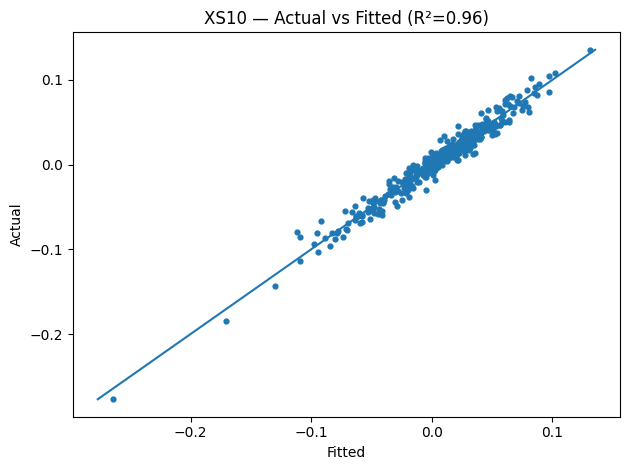

In [52]:
y_xs1 = use[pf]
plot_actual_vs_fitted(results[pf], y_xs1, title=f'{pf} — Actual vs Fitted')

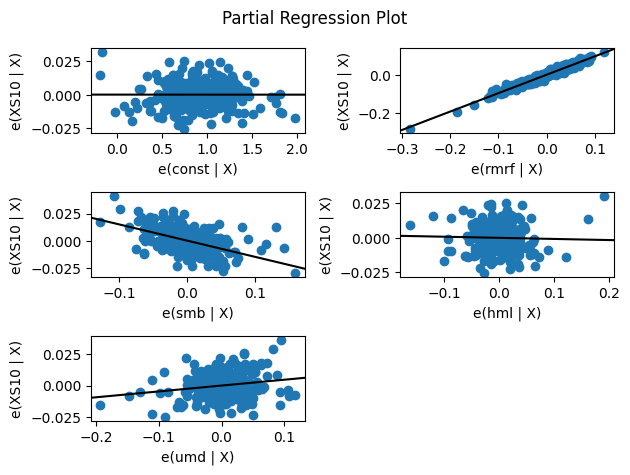

In [53]:
plot_partregress_grid(results[pf])
plt.tight_layout()
plt.show()

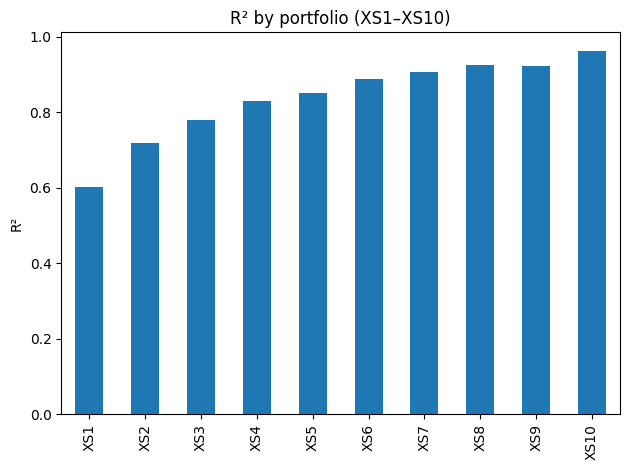

In [41]:
r2 = pd.Series({k: v.rsquared for k, v in results.items()})
r2 = r2.reindex(sorted(r2.index, key=lambda x: int(x[2:])))

plt.figure()
r2.plot(kind='bar')
plt.ylabel('R²')
plt.title('R² by portfolio (XS1–XS10)')
plt.tight_layout()
plt.show()